# Importing Dependencies & extracting dataset
----
This part of the process deals with the _Extraction_ part of the ***E***TL. Firstly, the needed modules will be imported and then the dataset. 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import tensorflow_datasets as tfds

Found GPU at: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import re

import keras
from keras.preprocessing import sequence as seq
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, LSTM, GlobalMaxPool1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import *

Using TensorFlow backend.


In [14]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [16]:
%cd /content/gdrive/My\ Drive/projects/capstoneIBM

/content/gdrive/My Drive/projects/capstoneIBM


In [3]:
!rm trainingandtestdata.zip -f
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip 
!unzip trainingandtestdata.zip
!mv training.1600000.processed.noemoticon.csv sentiment_analysis_trainingset.csv

--2020-06-29 16:09:15--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-06-29 16:09:15--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  60.2MB/s    in 1.3s    

2020-06-29 16:09:17 (60.2 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


## Loading the dataset into Pandas framework:

In [4]:
nameColumns = ["sentiment", "id", "date", "query", "user", "post"]

fullDataset = pd.read_csv('sentiment_analysis_trainingset.csv', 
                          header=None, 
                          names=nameColumns, 
                          encoding='latin1', 
                          engine='python')

In [5]:
fullDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   post       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# Tranformations
---
In this part, we will run the necessary data transformations (E***T***L):

## (re)tagging sentiments
Ensure that inputs labels will be `0` or `1`

In [6]:
DatasetLabels = fullDataset.sentiment.values
DatasetLabels[DatasetLabels == 4] = 1

## tweets text treatment
Here we will treat the Twitter text posts, to remove all sort of noise and non-essencial for our analysis:

In [7]:
def TweetTreament(stringTweet):
    tweet = re.sub(r"https?://[a-zA-Z0-9./]+", ' ', stringTweet)  # remove the URL links
    tweet = re.sub(r"(w|W){3}[a-zA-Z0-9./]+", ' ', tweet)         # remove the www references
    tweet = re.sub(r"@[a-zA-Z0-9]+", ' ', tweet)                  # remove references from accounts/profiles, using @ 
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)                  # keep only letters & punctuations marks
    tweet = re.sub(r" +", ' ', tweet).strip()                     # remove potential excess of whitespaces before, in and after
    
    return tweet

cleanedTweets = [TweetTreament(t) for t in fullDataset.post]

## tokenization
Tokenization is the process of converting each word in a text to an unique number (integer), called tokens. This is a common task in NLP, since computers learn words from numbers, not characters. Luckily, TensorFlow support us with all necessary methods.

The method `SubwordTextEncoder.build_from_corpus()` allows us to build a vocabulary using the universe of words in our dataset. 

The `.encode()` method convert each word in the Tweet into a token. This process is invertible by using `.decode()`.


In [8]:
targetVocab = 2**16

tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                                          cleanedTweets, 
                                          target_vocab_size=targetVocab)

tokenizedData = [tokenizer.encode(sentence) for sentence in cleanedTweets]

> **point of decision:** the vocabulary size is a critical variable, as a large vocabulary size will result in a high number of word embedding parameters in the model, and therefore a large storage or memory. 
> Searching in Google, we see that a average Englisch speaker knows around 20.000-40.000 words. For our experiment, we will use the `targetVocab = 2**16`, or the most 65.536 important words.

## padding
Since we will use a Convolutional Neural Network (CNN)  model, padding is required and it improves the model performance.

Some tweets have more words than others, and this is where the padding is necessary.

We need to have the inputs with the same size, so padding represents the process of normalizing the length for each tokenized tweet by completing it with `0`.

Luckily, Keras `sequence.pad_sequences()` does this task for us. For common length (`maxLength`) we will use the maximum length found in our sample. 

In [9]:
maxLength = max([len(p) for p in tokenizedData])

paddedData = tf.keras.preprocessing.sequence.pad_sequences(tokenizedData,
                                                           value=0,
                                                           padding="pre",
                                                           maxlen=maxLength)
print(maxLength)

73


In [10]:
paddedData[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,  1629,
         102, 65673,    11,     5,  2776,     2,   138,  5359,    47,
        1556, 42791,    16, 13542,   670,     1,    50,    30,     2,
       65702], dtype=int32)

# Loading

## Spliting data into training/testing set
As best practice, we will split our dataset in two groups: training set (80%) and testing set (20%).

In [11]:
testSize = int(len(paddedData) * 0.2)
print('The testing set has {0} datapoints\n'.format(testSize))

testInputs = paddedData[-testSize:]
testLabels = DatasetLabels[-testSize:]
trainInputs = paddedData[:-testSize]
trainLabels = DatasetLabels[:-testSize]

### Checking the shape of the model's inputs and labels 
print('Size of testing Inputs:', len(testInputs))
print('Size of testing Labels:', len(testLabels))
print('\nSize of training Inputs:', len(trainInputs))
print('Size of training Inputs:', len(trainLabels))
print('\nFirst observation of training label:', trainLabels[0])
print('\nFirst observation of training inputs:', trainInputs[0])
print('\nTraining inputs shape:', trainInputs[0].shape)

The testing set has 320000 datapoints

Size of testing Inputs: 320000
Size of testing Labels: 320000

Size of training Inputs: 1280000
Size of training Inputs: 1280000

First observation of training label: 0

First observation of training inputs: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0  1629   102 65673    11     5  2776     2
   138  5359    47  1556 42791    16 13542   670     1    50    30     2
 65702]

Training inputs shape: (73,)


# Model Specification, Training and Evaluation


## Final model
As a baseline model, the Long Short-Term Memory networks (LSTM) was chosen. 

The LSTM are a special type of Recurrent Neural Networks (RNN). 

RNNs models for text classification take in consideration not only individual words, but also the order they appear in.


In [19]:
def FinalModel():

  max_features = targetVocab
  maxlen = maxLength
  embedding_size = 128
  kernel_size = 5
  filters = 64

  print('CNN final model building...')
  model = Sequential()

  model.add(Embedding(max_features, 
                      embedding_size,
                      input_length=maxlen))
  model.add(SpatialDropout1D(0.5))
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='same',
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1024))
  model.add(Dropout(0.4))
  model.add(Activation('relu'))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  print('Compile CNN final model...')  
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

  return model

**initialization**

In [22]:
batch_size = 32
epoch = 10

finalModel = FinalModel()
finalModel.summary()

CNN final model building...
Compile CNN final model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 73, 128)           8388608   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 73, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 73, 64)            41024     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________

**training**

In [23]:
checkPath = './checkpoints/cnnFinal-weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkPath, monitor='val_acc', verbose=1, mode='max',save_best_only=True)

history = finalModel.fit(trainInputs, trainLabels,
          batch_size=batch_size,
          epochs=epoch,
          validation_data=(testInputs, testLabels),
          callbacks = [checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1280000 samples, validate on 320000 samples
Epoch 1/10
1280000/1280000 [==============================] - 254s 199us/step - loss: 0.4123 - acc: 0.8135 - val_loss: 0.6085 - val_acc: 0.7117

Epoch 00001: val_acc improved from -inf to 0.71171, saving model to ./checkpoints/cnnFinal-weights-improvement-01.hdf5
Epoch 2/10
1280000/1280000 [==============================] - 255s 199us/step - loss: 0.3709 - acc: 0.8382 - val_loss: 0.5976 - val_acc: 0.7473

Epoch 00002: val_acc improved from 0.71171 to 0.74725, saving model to ./checkpoints/cnnFinal-weights-improvement-02.hdf5
Epoch 3/10
1280000/1280000 [==============================] - 255s 199us/step - loss: 0.3546 - acc: 0.8474 - val_loss: 0.5257 - val_acc: 0.7429

Epoch 00003: val_acc did not improve from 0.74725
Epoch 4/10
1280000/1280000 [==============================] - 253s 198us/step - loss: 0.3432 - acc: 0.8537 - val_loss: 0.5886 - val_acc: 0.7409

Epoch 00004: val_acc did not improve from 0.74725
Epoch 5/10
1280000/1280000

**evalutation**

In [24]:
lossTrainBase, accTrainBase = finalModel.evaluate(trainInputs, trainLabels, batch_size=batch_size)
print("The results for the baseline model using under training set have an accuracy of {0} and a loss of {1}".format(lossTrainBase, accTrainBase))

lossTestBase, accTestBase = finalModel.evaluate(testInputs, testLabels, batch_size=batch_size)
print("The results for the baseline model using under testing set have an accuracy of {0} and a loss of {1}".format(lossTestBase, accTestBase))

1280000/1280000 [==============================] - 60s 47us/step
The results for the baseline model using under training set have an accuracy of 0.2425200029164087 and a loss of 0.9007124900817871
320000/320000 [==============================] - 15s 47us/step
The results for the baseline model using under testing set have an accuracy of 0.5908799258053303 and a loss of 0.7256812453269958


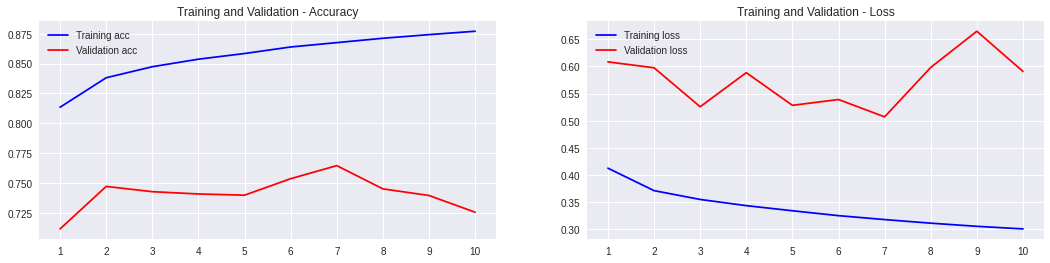

In [25]:
import matplotlib.pyplot as plt

def PlotEvaluation(history):
  plt.style.use('seaborn')
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(18, 4))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and Validation - Accuracy')
  plt.xticks(range(1, len(acc)+1, 1))
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation - Loss')
  plt.xticks(range(1, len(acc)+1, 1))    
  plt.legend()

PlotEvaluation (history)

# Deployment and benchmarking
As an application and, also to benchmark, the proposed system was compared with a on-market sentiment analysis tool. 

The NLTK’s VADER (Valence Aware Dictionary and sEntiment Reasoner)* was used for benchmarking: for a sample of sentences, it was tested how both system classify its sentiment.


In [68]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def textToEmbedding(stringText):
  wordToInt = [tokenizer.encode(stringText)]
  embedded = tf.keras.preprocessing.sequence.pad_sequences(wordToInt,
                                                           value=0,
                                                           padding="post",
                                                           maxlen=maxLength)
  return embedded



listSentence = ["That is not right",
                "That is fair",
                "He is cheating on me.",
                "He is a nice guy",
                "I like her voice",
                "She is getting on my nerves",
                "She is trustful",
                "He’s absolutely terrified of them",
                "Big Tech will cause the next market crash",
                "Big Tech will save the financial markets",
                "He just does not care",                                                
                "I cannot say that I liked this movie",
                "His behavior is not acceptable.",          
                "Data Science is awesome",
                "Deep Learning is cool",                 
                "That was a big waste of my time"]

for sentence in listSentence:
  forecast = finalModel.predict(textToEmbedding(sentence))
  if forecast[0][0] > 0.5:
    print(sentence, 'Positive', '%s' %forecast[0][0], '|%s' %sid.polarity_scores(sentence))
  else:
    print(sentence, 'Negative', '%s' %forecast[0][0], '|%s' %sid.polarity_scores(sentence))




[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
That is not right Negative 0.08131862 |{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
That is fair Positive 0.563975 |{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.3182}
He is cheating on me. Negative 0.026679963 |{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.5574}
He is a nice guy Positive 0.93541384 |{'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.4215}
I like her voice Positive 0.742467 |{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
She is getting on my nerves Negative 0.13213159 |{'neg': 0.219, 'neu': 0.781, 'pos': 0.0, 'compound': -0.1027}
She is trustful Positive 0.65043306 |{'neg': 0.0, 'neu': 0.392, 'pos': 0.608, 'compound': 0.4767}
He’s absolutely terrified of them Negative 0.06870688 |{'neg': 0.518, 'neu': 0.482, 'pos': 0.0, 'compound': -0.6478}
Big Tech will cause the next market crash Negative 0.207349